Please see below for the 6 geometric functions:
1. Volume of fluid (VOF) --> find_vof: Ratio of fluid region to overall rectangular design space, will range between 0 to 1

2. Number of outlets --> num_outlets: Number of outlet channels

3. Average outlet channel thickness --> outlet_thicknesses: The average ratio thickness of the outlet channel, with respect to overall height of design space, will range between 0 to 1

4. Average inlet channel thickness --> inlet_thicknesses: The average ratio thickness of the inlet channel, with respect to overall height of design space, will range between 0 to 1

5. Periemter --> perimeter: The number of pixels that surround the black fluid region, note that this function depends on subtract_inlet() and subtract_outlet() functions

6. Connectivity --> connectivity: The number of instances where channels diverge or converge, should be a count integer number

In [ ]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import openai
from openai import OpenAI
import os
import io
import re


# === SETUP ===
openai.api_key = "REDACTED"
client = OpenAI(api_key=openai.api_key)

In [ ]:
def find_vof_actual(image_path):
  image = Image.open(image_path)
  grayscale_image = image.convert('L')
  array = np.array(grayscale_image) < 128
  vof = np.sum(array) / array.size
  return vof

def num_outlets_actual(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')
    array = np.array(grayscale_image) > 128 # Pixels are either 1 (white), or 0 (black)

    switch_count = int(np.round(np.sum(array[:-1, -1] != array[1:, -1]) / 2))

    return switch_count

def outlet_thicknesses_actual(image_path):
  image = Image.open(image_path)
  grayscale_image = image.convert('L')
  array = np.array(grayscale_image) > 128 # Pixels are either 1 (white), or 0 (black)

  last_col = array[:, -1]
  thicknesses = []
  current_run = 0

  # Iterate through the last column
  for val in last_col:
    if val == 0:
      current_run += 1
    else:
      if current_run > 0:
        thicknesses.append(current_run/256) # Divide by the number of pixels in a column
      current_run = 0  # Reset

  if current_run > 0:
    thicknesses.append(current_run)

  if len(thicknesses) > 0:
    return sum(thicknesses) / len(thicknesses) # Average channel thickness
    #return sum(thicknesses) # Sum of thicknesses

  else:
    return 0


def inlet_thicknesses_actual(image_path):
  image = Image.open(image_path)
  grayscale_image = image.convert('L')
  array = np.array(grayscale_image) > 128 # Pixels are either 1 (white), or 0 (black)

  first_col = array[:, 0]
  thicknesses = []
  current_run = 0

  # Iterate through the first column
  for val in first_col:
    if val == 0:
      current_run += 1
    else:
      if current_run > 0:
        thicknesses.append(current_run/256) # Divide by the number of pixels in a column
      current_run = 0  # Reset


  if current_run > 0:
    thicknesses.append(current_run)

  if len(thicknesses) > 0:
    return sum(thicknesses) / len(thicknesses) # Average channel thickness
    #return sum(thicknesses) # Sum of thicknesses

  else:
    return 0





def subtract_inlet_actual(array):
  first_col = array[:, 0]
  thicknesses = []
  current_run = 0

  # Iterate through the first column
  for val in first_col:
    if val == 0:
      current_run += 1
    else:
      if current_run > 0:
        thicknesses.append(current_run) # Divide by the number of pixels in a column
      current_run = 0  # Reset


  if current_run > 0:
    thicknesses.append(current_run)

  return sum(thicknesses)


def subtract_outlet_actual(array):
  last_col = array[:, -1]
  thicknesses = []
  current_run = 0

  # Iterate through the last column
  for val in last_col:
    if val == 0:
      current_run += 1
    else:
      if current_run > 0:
        thicknesses.append(current_run) # Divide by the number of pixels in a column
      current_run = 0  # Reset

  if current_run > 0:
    thicknesses.append(current_run)

  return sum(thicknesses)

def perimeter_actual(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')
    array = np.array(grayscale_image) > 128 # Pixels are either 1 (white), or 0 (black)

    array = array.squeeze()
    #Obtain inlet and outlet thicknesses
    inlet = subtract_inlet(array)
    outlet = subtract_outlet(array)

    array = np.pad(array, pad_width=1, mode='constant', constant_values=0)

    # Convert the NumPy array to an OpenCV image
    img = cv2.cvtColor(array.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Convert to grayscale and 8-bit unsigned integer
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)

    # Find contours
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(f'{len(contours)} contours identified.')

    if contours:
        # Remove corner points
        height, width = array.shape
        corner_points = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
        corner_points_list = corner_points.tolist()

        filtered_contours = []

        for i, cnt in enumerate(contours):
            cnt_array = cnt.reshape(-1, 2)
            filtered_cnt = cnt_array[~np.any(np.isin(cnt_array, corner_points_list), axis=1)]
            filtered_contours.append(filtered_cnt)


            # Extract contour points
            x_coords, y_coords = filtered_cnt[:, 0], filtered_cnt[:, 1]

            # Plot the contour with a different color
            #plt.plot(x_coords, y_coords, color=colors[i % len(colors)], linewidth=2)
            #plt.scatter(x_coords, y_coords, color='red', s=3)



        # Calculate total perimeter
        total_perimeter = sum(cv2.arcLength(cnt, True) for cnt in filtered_contours)
        actual_perimeter = total_perimeter - 2*514 - (2 * 258 - inlet - outlet)

        # Plot the array (optional)
        #plt.imshow(array, cmap='gray', alpha=0.3)  # Add transparency to the image

        # Title and show the plot
        #plt.title(f"Perimeter: {actual_perimeter}")

        plt.show()
        return actual_perimeter
    else:
        return 0


def connectivity_actual(image_path):
  image = Image.open(image_path)
  grayscale_image = image.convert('L')
  array = np.array(grayscale_image) > 128 # Pixels are either 1 (white), or 0 (black)

  # Initialize a counter for changes
  change_count = 0

  # Iterate through each column
  for col_index in range(array.shape[1]-1):
    previous_column = int(np.round(np.sum(array[:-1, col_index] != array[1:, col_index]) / 2))
    current_column = int(np.round(np.sum(array[:-1, col_index+1] != array[1:, col_index+1]) / 2))
    if previous_column != current_column:
      change_count += 1

  return change_count



##test num_outlets

In [ ]:
import openai
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import io
import re


# === SETUP ===
openai.api_key = "REDACTED"
client = OpenAI(api_key=openai.api_key)

base_prompt = """Write a Python function named `num_outlets()` that counts the number of outlet channels in a numpy array representing a binary or grayscale image.
Inlet channels are always located on the **left** edge of the image, and outlet channels are located on the **right** edge of the image.
Return the number of **outlet** channels as an integer. Do not count inlets. The input is a numpy array."""


# === Extract Python code from GPT output ===
def extract_python_code(response_text):
    matches = re.findall(r"```(?:python)?(.*?)```", response_text, re.DOTALL)
    return matches[0].strip() if matches else response_text.strip()

# === Prompt GPT to generate num_outlets() ===
def get_outlet_function_from_gpt(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content

# === Upload image ===
def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        return filename

# === Run generated function on image ===
def run_generated_outlet_function(code_str, image_array):
    code_str = extract_python_code(code_str)
    local_vars = {}
    exec(code_str, globals(), local_vars)
    num_outlets_func = local_vars.get("num_outlets")
    if num_outlets_func is None:
        raise ValueError("Function `num_outlets()` not found.")
    return num_outlets_func(image_array)

# === MAIN LOOP ===
attempts = 0
mae_list = []
all_errors = []

while attempts < 10:
    print(f"\n📤 Upload a PNG image for attempt {attempts + 1}")
    image_path = upload_image()

    image = Image.open(image_path).convert('L')
    image_array = np.array(image)

    actual_count = num_outlets_actual(image_path)

    if attempts == 0:
        prompt = base_prompt
    else:
        feedback = f"\n\nFeedback: Your previous estimate had MAE = {mae_list[-1]:.4f}. Please improve the accuracy of your num_outlets() function."
        prompt = base_prompt + feedback

    print("🔁 Calling ChatGPT for num_outlets() function...")
    code = get_outlet_function_from_gpt(prompt)
    print("🧠 Function received from GPT:\n", code)

    try:
        pred_count = run_generated_outlet_function(code, image_array)
    except Exception as e:
        print("❌ Error running the generated function:", e)
        mae_list.append(10)  # Penalize failure
        attempts += 1
        continue

    error = abs(pred_count - actual_count)
    all_errors.append(error)
    mae = error if attempts == 0 else np.mean(all_errors)
    mae_list.append(mae)

    print(f"\n✅ Attempt {attempts + 1}:")
    print(f"Predicted Outlet Count: {pred_count}")
    print(f"Actual Outlet Count:    {actual_count}")
    print(f"Absolute Error:         {error}")
    print(f"MAE:                    {mae:.4f}")

    if mae < 0.1:
        print("\n🎯 Success: MAE is acceptable. Returning the final num_outlets() function:\n")
        print(extract_python_code(code))
        break
    else:
        print("\n⚠️ Not accurate enough. Please upload another image to help improve the model.\n")

    attempts += 1

# === PLOT MAE ===
plt.plot(range(1, len(mae_list)+1), mae_list, marker='o')
plt.title("Mean Absolute Error (MAE) for num_outlets() over Attempts")
plt.xlabel("Attempt")
plt.ylabel("MAE")
plt.grid(True)
plt.show()



📤 Upload a PNG image for attempt 1


Saving design_80.png to design_80 (2).png
🔁 Calling ChatGPT for num_outlets() function...
🧠 Function received from GPT:
 To solve this problem, we need to analyze the right edge of the given numpy array, which represents an image. The task is to count the number of distinct outlet channels on this edge. An outlet channel can be defined as a contiguous sequence of non-zero pixels (for binary images) or pixels above a certain threshold (for grayscale images) on the right edge of the image.

Here's a step-by-step approach to implement the `num_outlets()` function:

1. **Extract the Right Edge**: Get the last column of the numpy array, which represents the right edge of the image.

2. **Identify Outlets**: Traverse through this column to identify contiguous sequences of non-zero pixels. Each contiguous sequence represents an outlet channel.

3. **Count the Outlets**: Keep a count of these sequences.

Here's the implementation of the `num_outlets()` function:

```python
import numpy as np



Saving design_24.png to design_24.png
🔁 Calling ChatGPT for num_outlets() function...
🧠 Function received from GPT:
 To improve the accuracy of the `num_outlets()` function, we need to ensure that we correctly identify and count the outlet channels on the right edge of the image. Here's a refined version of the function:

```python
import numpy as np

def num_outlets(image):
    """
    Counts the number of outlet channels on the right edge of a binary or grayscale image.

    Parameters:
    image (numpy.ndarray): A 2D numpy array representing a binary or grayscale image.

    Returns:
    int: The number of outlet channels on the right edge of the image.
    """
    # Ensure the input is a 2D numpy array
    if not isinstance(image, np.ndarray) or image.ndim != 2:
        raise ValueError("Input must be a 2D numpy array.")

    # Get the right edge of the image
    right_edge = image[:, -1]

    # Identify unique segments on the right edge
    # We assume that a channel is represente

Saving design_19.png to design_19.png
🔁 Calling ChatGPT for num_outlets() function...
🧠 Function received from GPT:
 To improve the accuracy of the `num_outlets()` function, we need to ensure that we correctly identify and count the outlet channels on the right edge of the image. Here's a refined approach to achieve this:

1. **Identify Outlets**: We will scan the rightmost column of the image to identify continuous segments of non-zero values, which represent outlet channels.

2. **Count Outlets**: We will count these continuous segments to determine the number of outlet channels.

Here's the implementation of the `num_outlets()` function:

```python
import numpy as np

def num_outlets(image):
    # Ensure the input is a numpy array
    if not isinstance(image, np.ndarray):
        raise ValueError("Input must be a numpy array.")
    
    # Get the rightmost column of the image
    right_edge = image[:, -1]
    
    # Initialize variables to count outlets
    outlet_count = 0
    in_o

Saving design_195.png to design_195.png
🔁 Calling ChatGPT for num_outlets() function...
🧠 Function received from GPT:
 To improve the accuracy of the `num_outlets()` function, we need to ensure that we correctly identify and count the outlet channels on the right edge of the image. An outlet channel is defined as a continuous segment of non-zero pixels on the right edge of the image. Here's how you can implement this function:

```python
import numpy as np

def num_outlets(image):
    """
    Counts the number of outlet channels on the right edge of a binary or grayscale image.

    Parameters:
    image (numpy.ndarray): A 2D numpy array representing a binary or grayscale image.

    Returns:
    int: The number of outlet channels on the right edge of the image.
    """
    # Get the right edge of the image
    right_edge = image[:, -1]
    
    # Initialize the count of outlet channels
    outlet_count = 0
    
    # Flag to track if we are in an outlet channel
    in_outlet = False
 

KeyboardInterrupt: 

##Test average outlet channel thickness


📤 Upload a PNG image for attempt 1


Saving design_80.png to design_80 (8).png
🔁 Calling ChatGPT for outlet_thicknesses() function...
🧠 Function received from GPT:
 To calculate the average thickness of outlet channels in a binary or grayscale image, we can follow these steps:

1. Identify the outlet channels touching the rightmost edge of the image.
2. Measure the vertical span of each outlet channel.
3. Normalize the thickness by dividing by the total height of the image.
4. Calculate the average thickness of all outlet channels.

Here's a Python function that implements this logic using the `numpy` library:

```python
import numpy as np
from scipy.ndimage import label

def outlet_thicknesses(image):
    """
    Calculate the average thickness of outlet channels in a binary or grayscale image.

    Parameters:
    - image: numpy array representing the binary or grayscale image.

    Returns:
    - Average outlet thickness as a float between 0 and 1.
    """
    # Ensure the image is a binary image
    if image.dtype != 

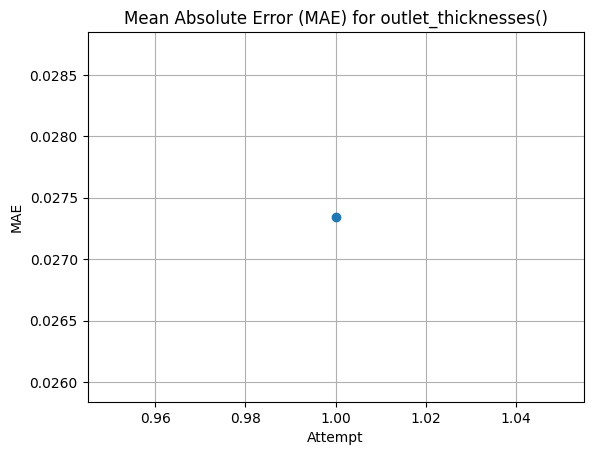

In [ ]:
!pip install --upgrade openai matplotlib scipy --quiet
import openai
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import io
import re


# === SETUP ===
openai.api_key = "REDACTED"
client = OpenAI(api_key=openai.api_key)
base_prompt = """Write a Python function called `outlet_thicknesses()` that calculates the average thickness of outlet channels in a binary or grayscale image represented as a numpy array.
Inlet channels are on the left and outlet channels are on the right side of the image.
Outlet thickness should be measured as the vertical span (in normalized units) of each outlet region touching the rightmost edge.
Return the average outlet thickness as a float between 0 and 1."""

# === Ground truth function (GPT doesn't see this) ===
def outlet_thicknesses_actual(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')
    array = np.array(grayscale_image) > 128

    last_col = array[:, -1]
    thicknesses = []
    current_run = 0

    for val in last_col:
        if val == 0:
            current_run += 1
        else:
            if current_run > 0:
                thicknesses.append(current_run / 256)
            current_run = 0

    if current_run > 0:
        thicknesses.append(current_run / 256)

    if len(thicknesses) > 0:
        return sum(thicknesses) / len(thicknesses)
    else:
        return 0

# === Extract Python code from GPT response ===
def extract_python_code(response_text):
    matches = re.findall(r"```(?:python)?(.*?)```", response_text, re.DOTALL)
    return matches[0].strip() if matches else response_text.strip()

# === Prompt GPT to write outlet_thicknesses() ===
def get_thickness_function_from_gpt(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content

# === Upload image ===
def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        return filename

# === Run the generated function safely with patching ===
def run_generated_thickness_function(code_str, image_array):
    import scipy.ndimage  # ensure module is loaded
    from scipy.ndimage import label as scipy_label

    code_str = extract_python_code(code_str)

    # Prepend import if it's missing from code block (safe fallback)
    if "label(" in code_str and "from scipy.ndimage import label" not in code_str:
        code_str = "from scipy.ndimage import label\n" + code_str

    # Make `label` available globally in case it's not in the code
    globals()["label"] = scipy_label

    local_vars = {}
    try:
        exec(code_str, globals(), local_vars)
        outlet_thicknesses = local_vars.get("outlet_thicknesses")
        if outlet_thicknesses is None:
            raise ValueError("Function `outlet_thicknesses()` not found.")
        return outlet_thicknesses(image_array)
    except Exception as e:
        raise RuntimeError(f"Failed to execute generated code: {e}")


# === MAIN LOOP ===
attempts = 0
mae_list = []
all_errors = []

while attempts < 10:
    print(f"\n📤 Upload a PNG image for attempt {attempts + 1}")
    image_path = upload_image()

    image = Image.open(image_path).convert('L')
    image_array = np.array(image)

    actual_thickness = outlet_thicknesses_actual(image_path)

    if attempts == 0:
        prompt = base_prompt
    else:
        feedback = f"\n\nFeedback: Your previous estimate had MAE = {mae_list[-1]:.4f}. Please improve the outlet_thicknesses() function."
        prompt = base_prompt + feedback

    print("🔁 Calling ChatGPT for outlet_thicknesses() function...")
    code = get_thickness_function_from_gpt(prompt)
    print("🧠 Function received from GPT:\n", code)

    try:
        pred_thickness = run_generated_thickness_function(code, image_array)
    except Exception as e:
        print("❌ Error running the generated function:", e)
        mae_list.append(1.0)
        attempts += 1
        continue

    error = abs(pred_thickness - actual_thickness)
    all_errors.append(error)
    mae = error if attempts == 0 else np.mean(all_errors)
    mae_list.append(mae)

    print(f"\n✅ Attempt {attempts + 1}:")
    print(f"Predicted Avg Thickness: {pred_thickness:.4f}")
    print(f"Actual Avg Thickness:    {actual_thickness:.4f}")
    print(f"Absolute Error:          {error:.4f}")
    print(f"MAE:                     {mae:.4f}")

    if mae < 0.1:
        print("\n🎯 Success: MAE is acceptable. Returning the final outlet_thicknesses() function:\n")
        print(extract_python_code(code))
        break
    else:
        print("\n⚠️ Not accurate enough. Please upload another image to improve the function.\n")

    attempts += 1

# === PLOT MAE ===
plt.plot(range(1, len(mae_list)+1), mae_list, marker='o')
plt.title("Mean Absolute Error (MAE) for outlet_thicknesses()")
plt.xlabel("Attempt")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

##Test average intlet channel thickness


📤 Upload a PNG image for attempt 1


Saving design_80.png to design_80 (1).png
🔁 Calling ChatGPT for inlet_thicknesses() function...
🧠 Function received from GPT:
 To calculate the average thickness of inlet channels in a binary or grayscale image, we need to identify the connected regions on the left edge of the image and measure their vertical spans. Here's a step-by-step implementation of the `inlet_thicknesses()` function:

```python
import numpy as np
from scipy.ndimage import label

def inlet_thicknesses(image):
    """
    Calculate the average thickness of inlet channels on the left edge of the image.

    Parameters:
    - image: A 2D numpy array representing a binary or grayscale image.

    Returns:
    - A float representing the average inlet thickness, normalized between 0 and 1.
    """
    # Ensure the image is binary
    if image.dtype != np.bool:
        # Convert grayscale to binary using a threshold
        threshold = image.max() / 2
        binary_image = image > threshold
    else:
        binary_ima

Saving design_11.png to design_11.png
🔁 Calling ChatGPT for inlet_thicknesses() function...
🧠 Function received from GPT:
 To improve the `inlet_thicknesses()` function, we need to ensure that we accurately identify and measure the vertical span of inlet channels touching the left edge of the image. The function should handle both binary and grayscale images, where inlet channels are represented by non-zero values. Here's an improved version of the function:

```python
import numpy as np
from scipy.ndimage import label

def inlet_thicknesses(image):
    """
    Calculate the average thickness of inlet channels in a binary or grayscale image.

    Parameters:
    - image: A 2D numpy array representing the image.

    Returns:
    - A float representing the average inlet thickness, normalized between 0 and 1.
    """
    # Ensure the image is a numpy array
    image = np.asarray(image)
    
    # Threshold the image to binary if it's grayscale
    if image.dtype != bool:
        image = 

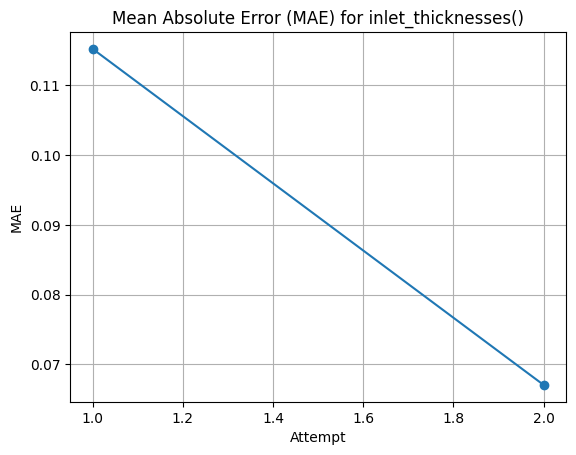

In [ ]:
# === Prompt for GPT ===
base_prompt = """Write a Python function called `inlet_thicknesses()` that calculates the average thickness of inlet channels in a binary or grayscale image represented as a numpy array.
Inlet channels are located on the **left edge** of the image, and outlet channels are on the right.
Inlet thickness should be measured as the vertical span (in normalized units) of each inlet region touching the leftmost edge.
Return the average inlet thickness as a float between 0 and 1."""

# === Ground Truth Function ===
def inlet_thicknesses_actual(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')
    array = np.array(grayscale_image) > 128

    first_col = array[:, 0]
    thicknesses = []
    current_run = 0

    for val in first_col:
        if val == 0:
            current_run += 1
        else:
            if current_run > 0:
                thicknesses.append(current_run / 256)
            current_run = 0

    if current_run > 0:
        thicknesses.append(current_run / 256)

    if len(thicknesses) > 0:
        return sum(thicknesses) / len(thicknesses)
    else:
        return 0

# === Helpers ===
def extract_python_code(response_text):
    matches = re.findall(r"```(?:python)?(.*?)```", response_text, re.DOTALL)
    return matches[0].strip() if matches else response_text.strip()

def get_inlet_function_from_gpt(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content

def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        return filename

# === Safe Function Runner with Global Patch for `label` ===
def run_generated_inlet_function(code_str, image_array):
    import scipy.ndimage
    from scipy.ndimage import label as scipy_label

    code_str = extract_python_code(code_str)

    # Patch if `label` is referenced
    if "label(" in code_str and "from scipy.ndimage import label" not in code_str:
        code_str = "from scipy.ndimage import label\n" + code_str

    globals()["label"] = scipy_label  # ensure label() resolves

    local_vars = {}
    try:
        exec(code_str, globals(), local_vars)
        inlet_thicknesses = local_vars.get("inlet_thicknesses")
        if inlet_thicknesses is None:
            raise ValueError("Function `inlet_thicknesses()` not found.")
        return inlet_thicknesses(image_array)
    except Exception as e:
        raise RuntimeError(f"Failed to execute generated code: {e}")

# === MAIN LOOP ===
attempts = 0
mae_list = []
all_errors = []

while attempts < 10:
    print(f"\n📤 Upload a PNG image for attempt {attempts + 1}")
    image_path = upload_image()

    image = Image.open(image_path).convert('L')
    image_array = np.array(image)

    actual_thickness = inlet_thicknesses_actual(image_path)

    if attempts == 0:
        prompt = base_prompt
    else:
        prompt = base_prompt + f"\n\nFeedback: Your previous estimate had MAE = {mae_list[-1]:.4f}. Please improve the inlet_thicknesses() function."

    print("🔁 Calling ChatGPT for inlet_thicknesses() function...")
    code = get_inlet_function_from_gpt(prompt)
    print("🧠 Function received from GPT:\n", code)

    try:
        pred_thickness = run_generated_inlet_function(code, image_array)
    except Exception as e:
        print("❌ Error running the generated function:", e)
        mae_list.append(1.0)
        attempts += 1
        continue

    error = abs(pred_thickness - actual_thickness)
    all_errors.append(error)
    mae = error if attempts == 0 else np.mean(all_errors)
    mae_list.append(mae)

    print(f"\n✅ Attempt {attempts + 1}:")
    print(f"Predicted Avg Inlet Thickness: {pred_thickness:.4f}")
    print(f"Actual Avg Inlet Thickness:    {actual_thickness:.4f}")
    print(f"Absolute Error:                {error:.4f}")
    print(f"MAE:                           {mae:.4f}")

    if mae < 0.1:
        print("\n🎯 Success: MAE is acceptable. Returning the final inlet_thicknesses() function:\n")
        print(extract_python_code(code))
        break
    else:
        print("\n⚠️ Not accurate enough. Please upload another image to improve the function.\n")

    attempts += 1

# === PLOT MAE ===
plt.plot(range(1, len(mae_list)+1), mae_list, marker='o')
plt.title("Mean Absolute Error (MAE) for inlet_thicknesses()")
plt.xlabel("Attempt")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


##Test perimeter function
MAE < 100

In [ ]:
# === GPT sees these two helpers ===
subtract_inlet_definition = """
def subtract_inlet(array):
    first_col = array[:, 0]
    thicknesses = []
    current_run = 0
    for val in first_col:
        if val == 0:
            current_run += 1
        else:
            if current_run > 0:
                thicknesses.append(current_run)
            current_run = 0
    if current_run > 0:
        thicknesses.append(current_run)
    return sum(thicknesses)
"""

subtract_outlet_definition = """
def subtract_outlet(array):
    last_col = array[:, -1]
    thicknesses = []
    current_run = 0
    for val in last_col:
        if val == 0:
            current_run += 1
        else:
            if current_run > 0:
                thicknesses.append(current_run)
            current_run = 0
    if current_run > 0:
        thicknesses.append(current_run)
    return sum(thicknesses)
"""

base_prompt = f"""
Below are two helper functions used in the image analysis task:

{subtract_inlet_definition}

{subtract_outlet_definition}

Now, write a function `perimeter(array)` that calculates the perimeter of the black (fluid) region in a binary numpy array.
- The fluid regions are black (0); background is white (1).
- Use OpenCV or numpy to find contours.
- Pad the array if needed to ensure contour detection.
- Subtract inlet and outlet channel sizes using the two helper functions above.
- Return a float representing the fluid region perimeter.
"""

# === Ground Truth Function (GPT does NOT see this) ===
def perimeter_actual(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')
    array = np.array(grayscale_image) > 128
    array = array.squeeze()

    inlet = subtract_inlet_actual(array)
    outlet = subtract_outlet_actual(array)

    array = np.pad(array, pad_width=1, mode='constant', constant_values=0)
    img = cv2.cvtColor(array.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)

    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        height, width = array.shape
        corner_points = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
        corner_points_list = corner_points.tolist()
        filtered_contours = []

        for cnt in contours:
            cnt_array = cnt.reshape(-1, 2)
            filtered_cnt = cnt_array[~np.any(np.isin(cnt_array, corner_points_list), axis=1)]
            filtered_contours.append(filtered_cnt)

        total_perimeter = sum(cv2.arcLength(cnt, True) for cnt in filtered_contours)
        actual_perimeter = total_perimeter - 2*514 - (2 * 258 - inlet - outlet)
        return actual_perimeter
    else:
        return 0

def subtract_inlet_actual(array):
    first_col = array[:, 0]
    thicknesses = []
    current_run = 0
    for val in first_col:
        if val == 0:
            current_run += 1
        else:
            if current_run > 0:
                thicknesses.append(current_run)
            current_run = 0
    if current_run > 0:
        thicknesses.append(current_run)
    return sum(thicknesses)

def subtract_outlet_actual(array):
    last_col = array[:, -1]
    thicknesses = []
    current_run = 0
    for val in last_col:
        if val == 0:
            current_run += 1
        else:
            if current_run > 0:
                thicknesses.append(current_run)
            current_run = 0
    if current_run > 0:
        thicknesses.append(current_run)
    return sum(thicknesses)

# === Utilities ===
def extract_python_code(response_text):
    matches = re.findall(r"```(?:python)?(.*?)```", response_text, re.DOTALL)
    return matches[0].strip() if matches else response_text.strip()

def get_perimeter_function_from_gpt(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content

def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        return filename

# === Safe runner with global patches ===
def run_generated_perimeter_function(code_str, image_array):
    import cv2
    import numpy as np

    # Convert boolean to uint8 (0 or 255) so OpenCV can handle it
    if image_array.dtype == bool:
        image_array = (~image_array).astype(np.uint8) * 255  # fluid = 0, background = 255
    elif image_array.dtype != np.uint8:
        image_array = image_array.astype(np.uint8)

    code_str = extract_python_code(code_str)

    # Inject known helpers
    global_vars = {}
    exec(subtract_inlet_definition, global_vars)
    exec(subtract_outlet_definition, global_vars)

    # Patch OpenCV and numpy imports if needed
    if "cv2" in code_str and "import cv2" not in code_str:
        code_str = "import cv2\n" + code_str
    if "np." in code_str and "import numpy as np" not in code_str:
        code_str = "import numpy as np\n" + code_str

    # Execute the function code and call it
    exec(code_str, global_vars)
    perimeter_fn = global_vars.get("perimeter")
    if perimeter_fn is None:
        raise ValueError("Function `perimeter()` not found in generated code.")
    return perimeter_fn(image_array)


# === MAIN LOOP ===
attempts = 0
mae_list = []
all_errors = []

while attempts < 10:
    print(f"\n📤 Upload a PNG image for attempt {attempts + 1}")
    image_path = upload_image()

    image = Image.open(image_path).convert('L')
    image_array = np.array(image) > 128  # binary format for input

    actual_value = perimeter_actual(image_path)

    prompt = base_prompt if attempts == 0 else base_prompt + f"\n\nFeedback: Your last estimate had MAE = {mae_list[-1]:.4f}. Please refine the function."

    print("🔁 Calling ChatGPT for perimeter() function...")
    code = get_perimeter_function_from_gpt(prompt)
    print("🧠 Function received from GPT:\n", code)

    try:
        pred_value = run_generated_perimeter_function(code, image_array)
    except Exception as e:
        print("❌ Error running the generated function:", e)
        mae_list.append(100)  # Penalize failure
        attempts += 1
        continue

    error = abs(pred_value - actual_value)
    all_errors.append(error)
    mae = error if attempts == 0 else np.mean(all_errors)
    mae_list.append(mae)

    print(f"\n✅ Attempt {attempts + 1}:")
    print(f"Predicted Perimeter: {pred_value:.2f}")
    print(f"Actual Perimeter:    {actual_value:.2f}")
    print(f"Absolute Error:      {error:.2f}")
    print(f"MAE:                 {mae:.4f}")

    if mae < 100:
        print("\n🎯 Success! Final GPT-generated `perimeter()` function:\n")
        print(extract_python_code(code))
        break
    else:
        print("\n⚠️ Not accurate enough. Please upload another image to improve it.\n")

    attempts += 1

# === PLOT MAE ===
plt.plot(range(1, len(mae_list)+1), mae_list, marker='o')
plt.title("Mean Absolute Error (MAE) for perimeter()")
plt.xlabel("Attempt")
plt.ylabel("MAE")
plt.grid(True)
plt.show()



📤 Upload a PNG image for attempt 1


NameError: name 'files' is not defined

##Test connectivity
Failed for design_80 (❌ Error running the generated function: Failed to execute generated code: name 'count_segments' is not defined), but works for design_167 (0 MAE)

In [ ]:
base_prompt = """Write a Python function called `connectivity()` that takes a 2D binary or grayscale numpy array as input and returns an integer count of how many times fluid channels diverge or converge.

- Fluid channels are black (pixel = 0).
- In each vertical column, you can detect how many separate vertical fluid segments exist.
- Count an event each time the number of segments changes between two consecutive columns (i.e., merge or split occurs).
- The function should return the total number of such change events across the width of the array."""

# === Hidden Ground Truth Function ===
def connectivity_actual(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')
    array = np.array(grayscale_image) > 128

    change_count = 0
    for col_index in range(array.shape[1] - 1):
        prev = int(np.round(np.sum(array[:-1, col_index] != array[1:, col_index]) / 2))
        curr = int(np.round(np.sum(array[:-1, col_index + 1] != array[1:, col_index + 1]) / 2))
        if prev != curr:
            change_count += 1
    return change_count

# === Utilities ===
def extract_python_code(response_text):
    matches = re.findall(r"```(?:python)?(.*?)```", response_text, re.DOTALL)
    return matches[0].strip() if matches else response_text.strip()

def get_connectivity_function_from_gpt(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content

def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        return filename

def run_generated_connectivity_function(code_str, image_array):
    import numpy as np

    # Ensure binary format (black = 0, white = 1)
    if image_array.dtype == bool:
        image_array = (~image_array).astype(np.uint8)
    elif image_array.dtype != np.uint8:
        image_array = (image_array < 128).astype(np.uint8)

    code_str = extract_python_code(code_str)

    # Fallback helper: count_segments
    fallback_count_segments = """
def count_segments(column):
    return int(np.round(np.sum(column[:-1] != column[1:]) / 2))
"""

    # Inject fallback if GPT uses but doesn’t define it
    if "count_segments(" in code_str and "def count_segments" not in code_str:
        code_str = fallback_count_segments + "\n" + code_str

    local_vars = {}
    try:
        exec(code_str, globals(), local_vars)
        connectivity_fn = local_vars.get("connectivity")
        if connectivity_fn is None:
            raise ValueError("Function `connectivity()` not found.")
        return connectivity_fn(image_array)
    except Exception as e:
        raise RuntimeError(f"Failed to execute generated code: {e}")


# === MAIN LOOP ===
attempts = 0
mae_list = []
all_errors = []

while attempts < 10:
    print(f"\n📤 Upload a PNG image for attempt {attempts + 1}")
    image_path = upload_image()

    image = Image.open(image_path).convert('L')
    image_array = np.array(image)

    actual_value = connectivity_actual(image_path)

    prompt = base_prompt if attempts == 0 else base_prompt + f"\n\nFeedback: Your previous attempt had MAE = {mae_list[-1]:.4f}. Please refine the function."

    print("🔁 Calling ChatGPT for connectivity() function...")
    code = get_connectivity_function_from_gpt(prompt)
    print("🧠 Function received from GPT:\n", code)

    try:
        pred_value = run_generated_connectivity_function(code, image_array)
    except Exception as e:
        print("❌ Error running the generated function:", e)
        mae_list.append(100)
        attempts += 1
        continue

    error = abs(pred_value - actual_value)
    all_errors.append(error)
    mae = error if attempts == 0 else np.mean(all_errors)
    mae_list.append(mae)

    print(f"\n✅ Attempt {attempts + 1}:")
    print(f"Predicted Connectivity: {pred_value}")
    print(f"Actual Connectivity:    {actual_value}")
    print(f"Absolute Error:         {error}")
    print(f"MAE:                    {mae:.4f}")

    if mae < 0.1:
        print("\n🎯 Success: MAE is acceptable. Final GPT-generated `connectivity()` function:\n")
        print(extract_python_code(code))
        break
    else:
        print("\n⚠️ Not accurate enough. Please upload another image to improve.\n")

    attempts += 1

# === PLOT MAE ===
plt.plot(range(1, len(mae_list)+1), mae_list, marker='o')
plt.title("Mean Absolute Error (MAE) for connectivity()")
plt.xlabel("Attempt")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


📤 Upload a PNG image for attempt 1


Saving design_80.png to design_80 (1).png
🔁 Calling ChatGPT for connectivity() function...
🧠 Function received from GPT:
 To solve this problem, we need to analyze the connectivity of fluid channels in a 2D binary or grayscale numpy array. The goal is to count the number of times fluid channels diverge or converge as we move from one column to the next. Here's how you can implement the `connectivity()` function:

```python
import numpy as np
from scipy.ndimage import label

def count_segments(column):
    """Helper function to count the number of separate fluid segments in a column."""
    # Consider fluid channels as 0, so we invert the column to find connected components
    inverted_column = 1 - column
    # Label connected components
    labeled_array, num_features = label(inverted_column)
    return num_features

def connectivity(array):
    # Ensure the input is a numpy array
    array = np.asarray(array)
    
    # Get the number of columns
    num_columns = array.shape[1]
    


Saving design_167.png to design_167.png
🔁 Calling ChatGPT for connectivity() function...
🧠 Function received from GPT:
 To solve this problem, we need to analyze the 2D array column by column and detect changes in the number of separate vertical fluid segments (black pixel segments) between consecutive columns. Each time the number of segments changes, it indicates a divergence or convergence event.

Here's a step-by-step approach to implement the `connectivity()` function:

1. **Identify Segments in a Column**: For each column, identify contiguous segments of black pixels (value 0). This can be done by iterating through the column and counting transitions from non-black to black pixels.

2. **Compare Consecutive Columns**: For each pair of consecutive columns, compare the number of segments. If the number of segments changes, it indicates a divergence or convergence event.

3. **Count Events**: Keep a count of how many times these changes occur as you move from the first to the last c

Saving design_161.png to design_161.png
🔁 Calling ChatGPT for connectivity() function...
🧠 Function received from GPT:
 To solve this problem, we need to analyze the 2D numpy array column by column to detect changes in the number of separate vertical fluid segments. A fluid segment is defined as a contiguous vertical sequence of black pixels (value 0). We will count the number of segments in each column and then compare consecutive columns to detect changes in the number of segments, which indicate either a merge or a split.

Here's a step-by-step approach to implement the `connectivity()` function:

1. Iterate through each column of the array.
2. For each column, count the number of separate fluid segments.
3. Compare the number of segments in the current column with the previous column.
4. If the number of segments changes, increment the event count.
5. Return the total number of change events.

Here's the implementation:

```python
import numpy as np

def count_segments(column):
   

Saving design_80.png to design_80.png


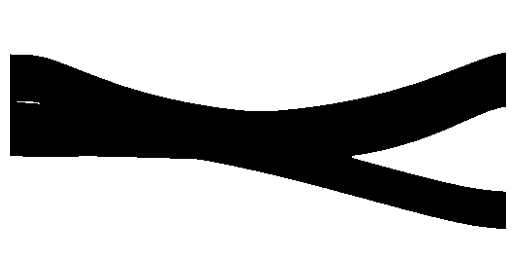

In [ ]:
# Step 1: Upload the file
from google.colab import files
uploaded = files.upload()

# Step 2: Load and display the image using Pillow and matplotlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Automatically use the uploaded file name
image_path = list(uploaded.keys())[0]
img = Image.open(image_path)

# Optional: convert image to NumPy array
img_array = np.array(img)

# Display the image
plt.imshow(img_array)
plt.axis('off')
plt.show()


In [ ]:
print(find_vof(image_path))
print(num_outlets_actual(image_path))
print(outlet_thicknesses_actual(image_path))
print(inlet_thicknesses_actual(image_path))
print(perimeter_actual(image_path))
print(connectivity_actual(image_path))


0.32230377197265625
2
0.18359375
0.41015625
1488.0508583784103
3
